In [231]:
from nltk.corpus import movie_reviews
import random
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.validation import check_is_fitted
nltk.download('movie_reviews')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix
from sklearn.model_selection import TunedThresholdClassifierCV
random.seed(42)
from sklearn.metrics import confusion_matrix, classification_report
import plotly.figure_factory as ff

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/heylucasleao/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [220]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)
texts = [" ".join(words) for words, label in documents]
labels = [label for words, label in documents]

In [221]:
df = pd.DataFrame({'Text': texts, 'Sentiment': labels})
#df = pd.concat([df[df['Sentiment'] == 'pos'], df[df['Sentiment'] == 'neg'].sample(frac=0.15, random_state=42)])
df["Sentiment"] = df["Sentiment"].replace({"pos": 1, "neg": 0})
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment'])

/tmp/ipykernel_123421/1738064572.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [222]:
class SentimentAnalyzer(ClassifierMixin, BaseEstimator):
    """A sentiment analysis classifier combining TF-IDF text vectorization with a machine learning model.

    This class wraps a scikit-learn compatible classifier with TF-IDF vectorization for text classification tasks.
    It handles the entire pipeline from text preprocessing to prediction, including probability calibration.

    """

    def __init__(
        self,
        learner: RandomForestClassifier,
        **tfidf_kwargs,
    ) -> None:
        """Initialize the SentimentAnalyzer with optional configurations.

        Args:
            learner_: Base estimator for classification. Defaults to balanced RandomForestClassifier.
            **tfidf_kwargs: Additional keyword arguments for TfidfVectorizer.
        """
        tfidf_params = {
            "max_features": 20000,
            "ngram_range": (1, 2),
            "min_df": 5,
            "max_df": 0.7,
            "sublinear_tf": True,
            "dtype": np.float32,
        }

        tfidf_kwargs = {**tfidf_params, **tfidf_kwargs}
        self.tfidf_ = TfidfVectorizer(**tfidf_kwargs)
        self.learner = learner
        self.oob_decision_function_ = None
        self.oob_logit_function_ = None
        self.is_fitted_ = False

    def __getattr__(self, name):
        return getattr(self.learner, name)

    def _check_is_fitted(self) -> None:
        """Check if both the TF-IDF vectorizer and learner are fitted."""
        if not self.is_fitted_:
            raise ValueError(
                "This %(name)s instance is not fitted yet. Call 'fit' with "
                "appropriate arguments before using this estimator."
                % {"name": type(self).__name__}
            )
        check_is_fitted(self.tfidf_)
        check_is_fitted(self.learner)

    def fit(self, X: np.ndarray, y: np.ndarray) -> "SentimentAnalyzer":
        """Fit the model to training data.

        Args:
            X: Training text data (iterable of strings).
            y: Target labels.

        Returns:
            self: Returns the instance itself.
        """
        self.learner.fit(self.tfidf_.fit_transform(X), y)
        epsilon = 1e-10
        y_prob = np.clip(self.learner.oob_decision_function_, epsilon, 1 - epsilon)
        self.oob_decision_function_ = self.learner.oob_decision_function_
        self.oob_logit_function_ = np.log(y_prob / (1 - y_prob))
        self.is_fitted_ = True
        return self

    def transform(self, X: np.ndarray) -> csr_matrix:
        """Transform text data using the fitted TF-IDF vectorizer."""
        self._check_is_fitted()
        return self.tfidf_.transform(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray[np.float64]:
        """Predict class probabilities for the input data."""
        return self.learner.predict_proba(self.transform(X))

    def predict_logit(self, X: np.ndarray) -> np.ndarray[np.float64]:
        """Predict log-odds (logit transform of probabilities) for the input data."""
        epsilon = 1e-10
        y_prob = np.clip(self.predict_proba(X), epsilon, 1 - epsilon)
        return np.log(y_prob / (1 - y_prob))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for the input data."""
        return self.learner.predict(self.transform(X))

In [223]:
learner = RandomForestClassifier(
            random_state=42, 
            oob_score=True, 
            n_jobs=-1, 
            class_weight="balanced", 
            max_depth=int(np.ceil(np.log2(len(X_train)) - 1)),
            min_samples_leaf=5
        )

In [224]:
sentiment_analyzer = SentimentAnalyzer(learner)
sentiment_analyzer.fit(X_train, y_train)

SentimentAnalyzer(learner=RandomForestClassifier(class_weight='balanced',
                                                 max_depth=10,
                                                 min_samples_leaf=5, n_jobs=-1,
                                                 oob_score=True,
                                                 random_state=42))

In [225]:
model = TunedThresholdClassifierCV(
    sentiment_analyzer, scoring="matthews_corrcoef"
).fit(X_train, y_train)

In [228]:
model.best_score_

0.6146273801044897

In [226]:
def cm(clf, X, y, fig_type=None, percentage_by_class=True):
    """
    Generates an annotated heatmap of the confusion matrix for a classifier.

    Args:
        clf: Classifier object (e.g., sklearn classifier).
        X: Input features.
        y: True labels.
        alpha: Optional parameter for classifier prediction.
        fig_type: Optional figure type (e.g., 'png', 'svg').
        percentage_by_class: If True, displays percentages by class; otherwise, overall percentages.

    Returns:
        Annotated heatmap of the confusion matrix.
    """

    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    labels = np.array([["FN", "TN"], ["TP", "FP"]])
    cm = np.array([[fn, tn], [tp, fp]])

    if percentage_by_class:
        total = cm.sum(axis=0)
        percentage = cm / total * 100
    else:
        percentage = cm / np.sum(cm) * 100

    annotation_text = np.empty_like(percentage, dtype="U10")

    for i in range(percentage.shape[0]):
        for j in range(percentage.shape[1]):
            annotation_text[i, j] = f"{labels[i, j]} {percentage[i, j]:.2f}"

    fig = ff.create_annotated_heatmap(
        cm,
        x=["Positive", "Negative"],
        y=["Negative", "Positive"],
        colorscale="Blues",
        hoverinfo="z",
        annotation_text=annotation_text,
    )

    fig.update_layout(width=400, height=400, title="Confusion Matrix")
    return fig.show(fig_type)

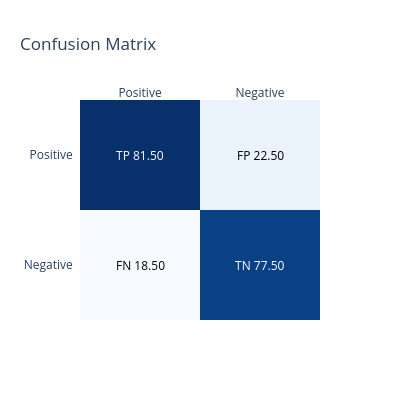

In [229]:
cm(model, X_test, y_test, fig_type="png")

In [233]:
print(f"{classification_report(y_test, model.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       200
           1       0.78      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.80      0.80      0.79       400

